## 2-Qubit Boltzmann Machine

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

In [201]:
def expmat(A):
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

def logmat(A):
    """
    Computes the natural logarithm of a given matrix `A`.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector)
        res += np.log(evals[i]) * projector
    return res


def generate_interaction_matrices():
    """
    Constructs the tensor product of Pauli matrices for each spin and 
    uses them to build the interaction matrices between the two spins.
    """
    pauI = np.array([[1,0],[0,1]],np.complex64)
    pauX = np.array([[0,1],[1,0]],np.complex64)
    pauY = np.array([[0,-1j],[1j,0]],np.complex64)
    pauZ = np.array([[1,0],[0,-1]],np.complex64)
    pau = np.zeros((4,4,4),np.complex64)
    pau = np.array([pauI,pauX,pauY,pauZ])

    interactions = np.zeros((4,4,4,4),dtype = np.complex64)
    for k in range(4):
        for kprime in range(4):
            interactions[k,kprime] = np.kron(pau[k],pau[kprime])
    return interactions

def hamiltonian2spins(w,interactions):
    """
    Calculates the Hamiltonian matrix of a two-spin system 
    """
    H = np.zeros((4,4),np.complex64)
    for k in range(4):
        for kprime in range(4):
            H += w[k,kprime] * interactions[k,kprime]
    return H

def rho_model(w,interactions):
    """
    Computes the density matrix of a two-spin system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H      = hamiltonian2spins(w,interactions)        #  get hamiltonian matrix
    rho    = expmat(H)                                #  defintion of rho
    Z      = np.real(np.trace(rho))                   #  get Z
    rho   /= Z                                        #  normalize such that Tr[rho] = 1
    return rho

def generate_w_random(seed):
    rng    = np.random.default_rng(seed)      #  set random seed for reproduciblity
    w      = rng.normal(size=(4,4))           #  get normal distributed weights
    w[0,0] = 0
    return w

def generate_w(wx1x2, wy1y2, w1z2z, hx1, hx2, hy1, hy2, hz1, hz2):
    return np.array([
        [0,  hx2, hy2, hz2],
        [hx1, wx1x2, 0,  0],
        [hy1, 0,  wy1y2, 0],
        [hz1, 0,  0,  w1z2z]
    ])

In [202]:
s = np.random.choice([0, 1], size=(2))
k = np.random.choice([0, 1], size=(2))

print("s before flipping:", s,k)

# Use boolean indexing to flip elements of s based on k
s[k == 1] = 1 - s[k == 1]

print("s after flipping:", s)


s before flipping: [0 1] [0 0]
s after flipping: [0 1]


In [272]:
def discrete_time_dynamics(w,t_vals,interactions):
    """
    Get transition matrix from parameters; use it to update dyamics
    """
    l = t_vals.shape[0]                             # amount of iterations
    s_vals = np.zeros((l,2))                        # array to store valuess
    H = hamiltonian2spins(w, interactions)          # get hamiltonian
    s = np.random.choice([0, 1], size=(2))          # initialize spins

    for i in range(l):
        k  = np.random.choice([0, 1], size=(2))     # choose which spins to flip, also allow no flip or 2-spin flip
        s[k == 1] = 1 - s[k == 1]                   # use boolean indexing to flip elements of s based on k
        s_kron = np.kron(s,s)                       # get the state applicable to the Hamiltonian
        g  = np.sum(np.exp(H @ s_kron))             # obtain probability of flip
        
        if g < np.random.rand():                    # accept state with proability g
            s_vals[i] = s                           # store the flipped state
        else:                                       # or reject it
            s[k == 1] = 1 - s[k == 1]               # restore the original state
            s_vals[i] = s                                 
    return s_vals

def generate_states(s_vals, t_vals):
    """Convert back to 0,1 formalism"""
    states = np.zeros(len(t_vals))
    for i in range(len(t_vals)):
        if s_vals[i][0] == 0 and s_vals[i][1] == 0:
            states[i] = 0

        if s_vals[i][0] == 0 and s_vals[i][1] == 1:
            states[i] = 1

        if s_vals[i][0] == 1 and s_vals[i][1] == 0:
            states[i] = 2

        if s_vals[i][0] == 1 and s_vals[i][1] == 1:
            states[i] = 3
            
    return states
        

In [292]:
def plot_dynamics(s_vals, t_vals):
    fig = plt.figure(figsize=(25, 6));                           #  make plots
    fig.suptitle("WHOOOO", fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

    states = generate_states(s_vals,t_vals)
    s1s2 = s_vals[:,0] * s_vals[:,1]


    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(t_vals,states)
    ax1.set_xlabel("time", fontsize=20)
    ax1.set_ylabel("states", fontsize=20)
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(t_vals,s_vals[:,0])
    ax2.plot(t_vals,s_vals[:,1])
    ax2.plot(t_vals,s1s2)
    ax2.set_xlabel("time", fontsize=20)
    ax2.set_ylabel("states", fontsize=20)

In [294]:
#PARAMETERS
dt = 0.01  #discrete time steps of simulation
sim_time = 2 #time simulation should run
t_vals = np.arange(0,sim_time,dt)

#interaction parameters
wx1x2 = 0
wy1y2 = 0
wz1z2 = 2
hx1   = 0
hx2   = 0
hy1   = 0
hy2   = 0
hz1   = 1
hz2   = 1
    
w = generate_w(wx1x2 ,wy1y2, wz1z2, hx1, hx2, hy1, hy2, hz1, hz2)
interactions = generate_interaction_matrices()

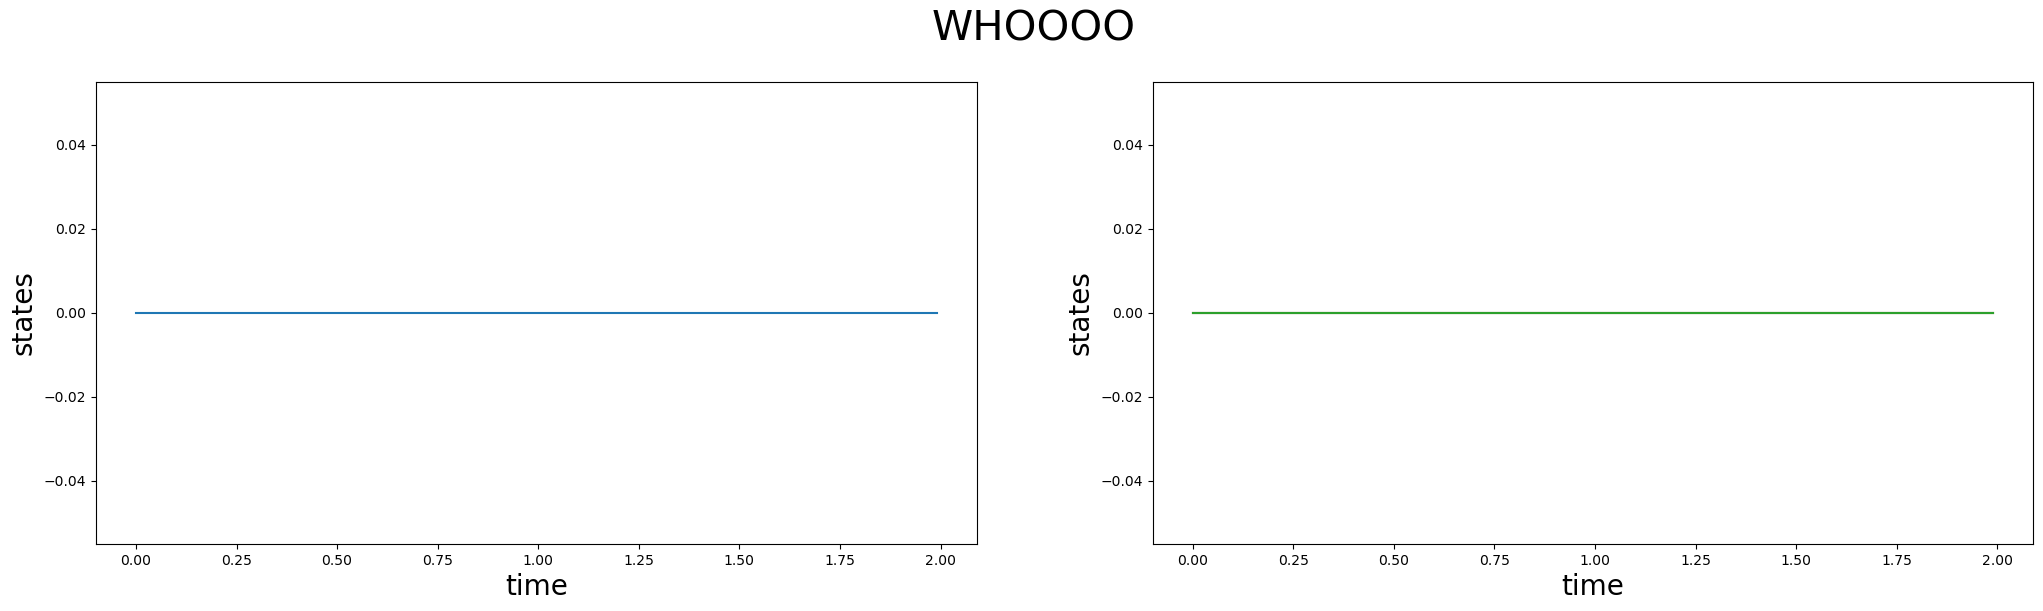

In [299]:
s = discrete_time_dynamics(w,t_vals,interactions)
plot_dynamics(s,t_vals)